In [4]:
import pickle
import pandas as pd
import numpy as np
# import matplotlib as plt
import matplotlib.pyplot as plt
import re
import urllib.request
import tensorflow as tf
import numpy as np
import konlpy

print(tf.__version__)
print(np.__version__)
# print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
0.5.2


## 데이터 로드

In [5]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7cccd0308700>)

In [6]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [7]:
print('훈련용 리뷰 개수 :',len(train_data)) # 훈련용 리뷰 개수 출력

훈련용 리뷰 개수 : 150000


In [8]:
train_data[:5] # 상위 5개 출력

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 데이터 정제

In [9]:
# document 열과 label 열의 중복을 제외한 값의 개수
train_data['document'].nunique(), train_data['label'].nunique()

(146182, 2)

In [10]:
# document 열의 중복 제거
train_data.drop_duplicates(subset=['document'], inplace=True)

In [11]:
print(train_data.groupby('label').size().reset_index(name = 'count'))

   label  count
0      0  73342
1      1  72841


In [12]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [13]:
#알파벳과 공백을 제외하고 모두 제거
eng_text = 'do!!! you expect... people~ to~ read~ the FAQ, etc. and actually accept hard~! atheism?@@'
print(re.sub(r'[^a-zA-Z ]', '', eng_text))

do you expect people to read the FAQ etc and actually accept hard atheism


In [14]:
# 한글과 공백을 제외하고 모두 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)
train_data[:5]

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1


In [15]:
train_data['document'] = train_data['document'].str.replace('^ +', "", regex=True) # white space 데이터를 empty value로 변경
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

id            0
document    789
label         0
dtype: int64


In [16]:
train_data.loc[train_data.document.isnull()][:5]

,id,document,label
404,4221289,NaN,0
412,9509970,NaN,1
470,10147571,NaN,1
584,7117896,NaN,0
593,6478189,NaN,0


In [17]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))
print('After dropnaing a train_data\n',train_data.isnull().sum())

nsm_sentence = train_data['document']
nsm_sentence

145393
After dropnaing a train_data
 id          0
document    0
label       0
dtype: int64


0                                         아 더빙 진짜 짜증나네요 목소리
1                                흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                                 교도소 이야기구먼 솔직히 재미는 없다평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...
                                ...                        
149995                                      인간이 문제지 소는 뭔죄인가
149996                                           평점이 너무 낮아서
149997                        이게 뭐요 한국인은 거들먹거리고 필리핀 혼혈은 착하다
149998                           청춘 영화의 최고봉방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 145393, dtype: object

In [18]:
test_data.drop_duplicates(subset = ['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True) # 정규 표현식 수행
test_data['document'] = test_data['document'].str.replace('^ +', "", regex=True) # 공백은 empty 값으로 변경
test_data['document'].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
test_data = test_data.dropna(how='any') # Null 값 제거
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))



전처리 후 테스트용 샘플의 개수 : 48852


Min length :  1
Max length :  140
Average length :  33


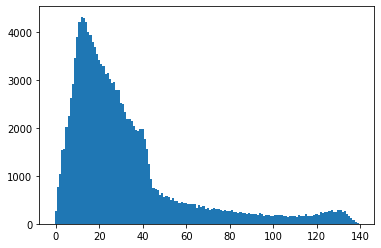

In [19]:
import matplotlib.pyplot as plt

min_len = 999
max_len = 0
sum_len = 0

for s in nsm_sentence:
  if len(s) < min_len :
    min_len = len(s)
  if len(s) > max_len :
    max_len = len(s)
  sum_len += len(s)

print('Min length : ', min_len)
print('Max length : ', max_len)
print('Average length : ', sum_len // len(nsm_sentence))

sen_length_cnt = [0] * max_len
for sen in nsm_sentence:
  sen_length_cnt[len(sen)-1] += 1

plt.bar(range(max_len), sen_length_cnt, width=1.0)
plt.show()

In [20]:
max_len = 140
min_len = 10

nsm_filtered_sen = []
nsm_filtered_target = []

target = np.array(train_data['label'])

for s, t in zip(nsm_sentence, target):
  if (len(str(s)) < max_len) and (len(str(s)) >= min_len) :
    nsm_filtered_sen.append(s)
    nsm_filtered_target.append(t)
    
print(len(nsm_filtered_sen))
print(len(nsm_filtered_target))

130390
130390


In [21]:
def sp_tokenize(s, corpus, vocab_path="./korean_spm.vocab", padding='post'): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open(vocab_path, 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding=padding)

    return tensor, word_index, index_word

## Sentence Piece Model Train

In [22]:
import sentencepiece as spm
import os
nsm_temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/nsm_train_bpe.txt.temp'

vocab_size = 8000

with open(nsm_temp_file, 'w') as f:
    for row in nsm_sentence:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm_nsm_bpe --model_type=bpe --vocab_size={}'.format(nsm_temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/nsm_train_bpe.txt.temp --model_prefix=korean_spm_nsm_bpe --model_type=bpe --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/nsm_train_bpe.txt.temp
  input_format: 
  model_prefix: korean_spm_nsm_bpe
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
 

-rw-r--r-- 1 root root 376816 Feb 25 03:09 korean_spm.model
-rw-r--r-- 1 root root 533947 Feb 25 03:13 korean_spm_naver_sentiment_movie.model
-rw-r--r-- 1 root root 310400 Feb 25 03:13 korean_spm_naver_sentiment_movie.vocab
-rw-r--r-- 1 root root 373419 Feb 25 07:40 korean_spm_nsm_bpe.model
-rw-r--r-- 1 root root 118628 Feb 25 07:40 korean_spm_nsm_bpe.vocab
-rw-r--r-- 1 root root 377804 Feb 25 06:14 korean_spm_nsm.model
-rw-r--r-- 1 root root 147291 Feb 25 06:14 korean_spm_nsm.vocab
-rw-r--r-- 1 root root 146213 Feb 25 03:09 korean_spm.vocab


In [23]:
nsm_spm = spm.SentencePieceProcessor()
nsm_spm.Load('./korean_spm_nsm_bpe.model')

True

In [40]:
nsm_tensor, nsm_word_index, nsme_index_word = sp_tokenize(nsm_spm, nsm_filtered_sen, "./korean_spm_nsm_bpe.vocab", padding='pre')
print(nsm_tensor.shape)
print(nsm_tensor)
print(len(nsm_word_index))
print(len(nsme_index_word))

(130390, 111)
[[   0    0    0 ... 2293   35 2010]
 [   0    0    0 ... 6455   63  393]
 [   0    0    0 ... 1170 1757  275]
 ...
 [   0    0    0 ... 6471 1428   77]
 [   0    0    0 ...   80 6456 6522]
 [   0    0    0 ...  616 5516    4]]
8000
8000


In [41]:
# 데이터 나누기
from sklearn.model_selection import train_test_split

x_train, val_x, y_train, val_y = train_test_split(nsm_tensor, nsm_filtered_target, test_size=0.2)
y_train = np.array(y_train)
val_y = np.array(val_y)

In [42]:
print(x_train.shape)
print(y_train.shape)
print(val_y.shape)

(104312, 111)
(104312,)
(26078,)


## LSTM으로 네이버 영화 리뷰 감성 분류하기

In [43]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128


model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(LSTM(hidden_units))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)


Epoch 1/15
1304/1304 [==============================] - 13s 9ms/step - loss: 0.4093 - acc: 0.8115 - val_loss: 0.3727 - val_acc: 0.8379

Epoch 00001: val_acc improved from -inf to 0.83794, saving model to best_model.h5
Epoch 2/15
1304/1304 [==============================] - 11s 8ms/step - loss: 0.3242 - acc: 0.8596 - val_loss: 0.3377 - val_acc: 0.8542

Epoch 00002: val_acc improved from 0.83794 to 0.85424, saving model to best_model.h5
Epoch 3/15
1304/1304 [==============================] - 11s 8ms/step - loss: 0.2980 - acc: 0.8719 - val_loss: 0.3306 - val_acc: 0.8561

Epoch 00003: val_acc improved from 0.85424 to 0.85611, saving model to best_model.h5
Epoch 4/15
1304/1304 [==============================] - 11s 8ms/step - loss: 0.2782 - acc: 0.8827 - val_loss: 0.3373 - val_acc: 0.8549

Epoch 00004: val_acc did not improve from 0.85611
Epoch 5/15
1304/1304 [==============================] - 11s 8ms/step - loss: 0.2597 - acc: 0.8915 - val_loss: 0.3368 - val_acc: 0.8536

Epoch 00005: val_a

In [44]:
load_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (load_model.evaluate(val_x, val_y)[1]))

815/815 [==============================] - 3s 3ms/step - loss: 0.3308 - acc: 0.8568

 테스트 정확도: 0.8568


### 회고

팀에서 데이터 전처리와 RNN 모델을 정의 한 후 vocab_size, padding, model_type에 변경에 따른 정확성 정도를 측정 하기로 진행 하였습니다.

제 케이스는 vocab_size=8000, padding=post,pre, model_type(spm)=unigram, bpe 였습니다.

8000	post-padding	unigram		0.5046
		post-padding	bpe		    0.5035
		pre-padding	    unigram		0.8577
		pre-padding	    bpe		    0.8578
        
제 케이스의 결과는 sentencepiece의 모델 타입에 따른 차이는 없었고, 토근의 패딩 방식에 따라 차이가 많이 났습니다.
한글 이라 pre padding이 조금 좋은 결과가 나올 거라 예상 했는데, 너무 차이가 많이 났어 어떻게 해석해야 할지 모르겠습니다.

        
데이터 전처리와 RNN 모델이 동일한 조건에서,
konlpy의 Okt로 진행 했을때 정확도가 0.8544 였어, 위 pre padding과 차이가 크지 않았습니다.

lecture에서 언급 된 데로 subword 방식으로 토큰화 하여도 언어에 따른 차이가 크지 않다는 것을 확인 할 수 있었습니다.